## Загрузим нужные библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem

## tfidf
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from sklearn import feature_selection
from sklearn.feature_selection import chi2
#from sklearn.feature_selection import SelectKBest


%matplotlib inline

In [2]:
df = pd.read_csv("./content/train_dataset_train.csv")

In [3]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/helgi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/helgi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
import re
cleaner = re.compile('<.*?>|\&nbsp;')
def cleanhtml(income):
    cleantext = re.sub(cleaner, ' ', income)
    return cleantext

def parse_date(income):
  date = re.sub(r"[0-9]{1,2}\.[0-9]{1,2}(\.[0-9]{2,4}){0,1}", " DATE ", income)
  return date

def mark_numbers(income):
  date = re.sub(r"[0-9]+", " NUM ", income)
  return date


df['plain'] = df["Текст Сообщения"].apply(lambda str: cleanhtml(str))

In [5]:
df['plain']

0       Помогите начальник Льговского рэс не реагирует...
1        По фасаду дома по адресу ул. Урицкого 22 прох...
2       Агресивные собаки. На радуге там стая из подро...
3        На пересечении  улиц Сосновская и Береговая  ...
4         Здравствуйте! Рядом с домом 1 «А» по улице С...
                              ...                        
1995     22.12.21 в вечернее время появилась вонь от Г...
1996     Добрый день! Хочу сообщить о такой проблеме -...
1997    Состоят 3 засохшие дерева (2 большие  берёзы и...
1998    Пожалуйста роман Владимирович, в скором времен...
1999     Сдан ПЦР-тест 29.10.2021г., но результат тест...
Name: plain, Length: 2000, dtype: object

In [6]:
df['text'] = df['plain'].map(lambda str: str.lower())
#df['text'] = df["text"].apply(lambda str: parse_date(str))
#df['text'] = df["text"].apply(lambda str: mark_numbers(str))

In [7]:
#mystem = Mystem()
#df['text'] = df['text'].apply(lambda str: mystem.lemmatize(str))

In [8]:
df['text'] = df["text"].apply(lambda str: nltk.tokenize.word_tokenize(str))
df['text'] = df['text'].apply(lambda str: [morph.parse(token)[0].normal_form for token in str])

In [9]:
import string
df['text'] = df['text'].map(lambda str: [token for token in str if token not in string.punctuation])

In [10]:
df['text'] = df['text'].map(lambda str: [token for token in str if token not in nltk.corpus.stopwords.words("russian")])

In [11]:
df['text'] = df['text'].map(lambda str: [token for token in str if token.isalpha()])

In [12]:
df['text'] = df['text'].map(lambda str:' '.join(str))

In [13]:
df.text

0       помочь начальник льговский рэс реагировать жал...
1       фасад дом адрес ул урицкий проходить труба газ...
2       агресивный собака радуга стая подрасти щенок з...
3       пересечение улица сосновский береговой завалит...
4       здравствуйте рядом дом улица светлый вне придо...
                              ...                        
1995         вечерний время появиться вонь грибной радуга
1996    добрый день хотеть сообщить проблема возле наш...
1997    состоять засохнуть дерево больший берёза ещё д...
1998    пожалуйста роман владимирович скорый время мно...
1999      сдать результат тест портал госуслуга поступить
Name: text, Length: 2000, dtype: object

In [14]:
#count_vectorizer = CountVectorizer(ngram_range=[1,3], analyzer='char', binary=False, tokenizer=str.split)
#count_vectorizer = CountVectorizer(ngram_range=[1,3], analyzer='char', binary=False, tokenizer=nltk.tokenize.word_tokenize)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))

In [15]:
bag_of_words = tfidf_vectorizer.fit_transform(df["text"])
#bag_of_words = count_vectorizer.fit_transform(df["Текст Сообщения"])
#bag_of_words = count_vectorizer.fit_transform(df["text"])

In [16]:
bag_of_words

<2000x56057 sparse matrix of type '<class 'numpy.float64'>'
	with 117653 stored elements in Compressed Sparse Row format>

In [17]:
#feature_names = count_vectorizer.get_feature_names()
feature_names = tfidf_vectorizer.get_feature_names()


In [18]:
df_cvect = pd.DataFrame(bag_of_words.toarray(), columns = feature_names)

In [19]:
df_cvect.head(3)

,ammann,ammann пос,amp,amp белый,baw,baw street,cental,cental park,covid,covid выздороветь,...,ящик,ящик жить,ящик просить,ёж,ёж год,ёлка,ёлка новый,ёлка озеленить,ёлочка,ёлочка надеяться
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Выделим выборки

In [20]:
#X = df.drop(["Категория", "Текст Сообщения", "id"], axis = 1)
#y = df[["Категория"]]
X = df_cvect
y = df[["Категория"]]

In [21]:
print(y.shape, X.shape, np.array(feature_names).shape)

(2000, 1) (2000, 56057) (56057,)


In [22]:
y_sel = y
X_names = feature_names
p_value_limit = 0.95

dtf_features = pd.DataFrame()
for cat in range(17):
    chi2, p = feature_selection.chi2(X, y_sel==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
    
X_names = dtf_features["feature"].unique().tolist()

In [23]:
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)

In [24]:
vectorizer.fit(df["text"])
bow1 = vectorizer.transform(df["text"])

In [25]:
bow1

<2000x6569 sparse matrix of type '<class 'numpy.float64'>'
	with 12472 stored elements in Compressed Sparse Row format>

In [26]:
dic_vocabulary = vectorizer.vocabulary_

In [27]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [28]:
X2 = pd.DataFrame(bow1.toarray(), columns = dic_vocabulary)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.3, random_state=42)

## Обучение модели

In [30]:
counts = y_train["Категория"].value_counts()
max_c = max(counts)

In [31]:
cw = {x:max_c/counts[x] for x in range(17)}

In [32]:
cw

{0: 2.104294478527607,
 1: 49.0,
 2: 686.0,
 3: 1.0,
 4: 9.942028985507246,
 5: 85.75,
 6: 85.75,
 7: 34.3,
 8: 7.072164948453608,
 9: 171.5,
 10: 20.176470588235293,
 11: 57.166666666666664,
 12: 686.0,
 13: 76.22222222222223,
 14: 171.5,
 15: 171.5,
 16: 6.660194174757281}

In [33]:
#clf = RandomForestClassifier(random_state=0, class_weight=cw)
clf = CatBoostClassifier(random_state=0,  loss_function='MultiClass', class_weights = cw) #auto_class_weights='Balanced')
#from sklearn.linear_model import SGDClassifier #0.5
#clf = SGDClassifier()

In [34]:
clf.fit(X_train, y_train)

Learning rate set to 0.080496
0:	learn: 2.7653350	total: 103ms	remaining: 1m 43s
1:	learn: 2.7623233	total: 155ms	remaining: 1m 17s
2:	learn: 2.7182747	total: 208ms	remaining: 1m 9s
3:	learn: 2.6930703	total: 260ms	remaining: 1m 4s
4:	learn: 2.6733337	total: 311ms	remaining: 1m 1s
5:	learn: 2.6526212	total: 361ms	remaining: 59.8s
6:	learn: 2.6410181	total: 410ms	remaining: 58.2s
7:	learn: 2.6169760	total: 463ms	remaining: 57.4s
8:	learn: 2.5868607	total: 513ms	remaining: 56.5s
9:	learn: 2.5664719	total: 565ms	remaining: 55.9s
10:	learn: 2.5547528	total: 619ms	remaining: 55.6s
11:	learn: 2.5374012	total: 671ms	remaining: 55.2s
12:	learn: 2.5175147	total: 722ms	remaining: 54.8s
13:	learn: 2.5097371	total: 772ms	remaining: 54.4s
14:	learn: 2.4755859	total: 824ms	remaining: 54.1s
15:	learn: 2.4685971	total: 877ms	remaining: 53.9s
16:	learn: 2.4504586	total: 928ms	remaining: 53.7s
17:	learn: 2.4296728	total: 979ms	remaining: 53.4s
18:	learn: 2.3921257	total: 1.03s	remaining: 53.1s
19:	learn

162:	learn: 0.8712936	total: 8.67s	remaining: 44.5s
163:	learn: 0.8673231	total: 8.73s	remaining: 44.5s
164:	learn: 0.8622923	total: 8.78s	remaining: 44.5s
165:	learn: 0.8550823	total: 8.84s	remaining: 44.4s
166:	learn: 0.8492457	total: 8.89s	remaining: 44.3s
167:	learn: 0.8453929	total: 8.94s	remaining: 44.3s
168:	learn: 0.8393787	total: 9s	remaining: 44.2s
169:	learn: 0.8363133	total: 9.05s	remaining: 44.2s
170:	learn: 0.8322590	total: 9.1s	remaining: 44.1s
171:	learn: 0.8269740	total: 9.15s	remaining: 44.1s
172:	learn: 0.8215961	total: 9.21s	remaining: 44s
173:	learn: 0.8153372	total: 9.26s	remaining: 44s
174:	learn: 0.8110636	total: 9.31s	remaining: 43.9s
175:	learn: 0.8078832	total: 9.37s	remaining: 43.8s
176:	learn: 0.8034568	total: 9.42s	remaining: 43.8s
177:	learn: 0.7996090	total: 9.47s	remaining: 43.7s
178:	learn: 0.7953079	total: 9.52s	remaining: 43.7s
179:	learn: 0.7918156	total: 9.58s	remaining: 43.6s
180:	learn: 0.7876426	total: 9.63s	remaining: 43.6s
181:	learn: 0.783586

322:	learn: 0.4907613	total: 17.3s	remaining: 36.3s
323:	learn: 0.4895600	total: 17.4s	remaining: 36.2s
324:	learn: 0.4886306	total: 17.4s	remaining: 36.2s
325:	learn: 0.4879361	total: 17.5s	remaining: 36.1s
326:	learn: 0.4868896	total: 17.5s	remaining: 36.1s
327:	learn: 0.4856600	total: 17.6s	remaining: 36s
328:	learn: 0.4849937	total: 17.6s	remaining: 36s
329:	learn: 0.4838340	total: 17.7s	remaining: 35.9s
330:	learn: 0.4827868	total: 17.7s	remaining: 35.9s
331:	learn: 0.4814220	total: 17.8s	remaining: 35.8s
332:	learn: 0.4806966	total: 17.9s	remaining: 35.8s
333:	learn: 0.4800781	total: 17.9s	remaining: 35.7s
334:	learn: 0.4797018	total: 18s	remaining: 35.6s
335:	learn: 0.4784555	total: 18s	remaining: 35.6s
336:	learn: 0.4777275	total: 18.1s	remaining: 35.5s
337:	learn: 0.4767379	total: 18.1s	remaining: 35.5s
338:	learn: 0.4756907	total: 18.2s	remaining: 35.4s
339:	learn: 0.4740604	total: 18.2s	remaining: 35.4s
340:	learn: 0.4729649	total: 18.3s	remaining: 35.3s
341:	learn: 0.471807

482:	learn: 0.3625111	total: 25.9s	remaining: 27.7s
483:	learn: 0.3618701	total: 25.9s	remaining: 27.6s
484:	learn: 0.3615467	total: 26s	remaining: 27.6s
485:	learn: 0.3611924	total: 26s	remaining: 27.5s
486:	learn: 0.3609201	total: 26.1s	remaining: 27.5s
487:	learn: 0.3603751	total: 26.1s	remaining: 27.4s
488:	learn: 0.3600106	total: 26.2s	remaining: 27.4s
489:	learn: 0.3597610	total: 26.3s	remaining: 27.3s
490:	learn: 0.3595481	total: 26.3s	remaining: 27.3s
491:	learn: 0.3591995	total: 26.4s	remaining: 27.2s
492:	learn: 0.3586696	total: 26.4s	remaining: 27.2s
493:	learn: 0.3582068	total: 26.5s	remaining: 27.1s
494:	learn: 0.3577416	total: 26.5s	remaining: 27.1s
495:	learn: 0.3571433	total: 26.6s	remaining: 27s
496:	learn: 0.3568165	total: 26.6s	remaining: 26.9s
497:	learn: 0.3562822	total: 26.7s	remaining: 26.9s
498:	learn: 0.3560962	total: 26.7s	remaining: 26.8s
499:	learn: 0.3556995	total: 26.8s	remaining: 26.8s
500:	learn: 0.3551570	total: 26.8s	remaining: 26.7s
501:	learn: 0.3549

642:	learn: 0.3073119	total: 34.4s	remaining: 19.1s
643:	learn: 0.3071022	total: 34.5s	remaining: 19.1s
644:	learn: 0.3058970	total: 34.5s	remaining: 19s
645:	learn: 0.3056408	total: 34.6s	remaining: 19s
646:	learn: 0.3055627	total: 34.7s	remaining: 18.9s
647:	learn: 0.3052812	total: 34.7s	remaining: 18.9s
648:	learn: 0.3049686	total: 34.8s	remaining: 18.8s
649:	learn: 0.3047173	total: 34.8s	remaining: 18.8s
650:	learn: 0.3045997	total: 34.9s	remaining: 18.7s
651:	learn: 0.3044656	total: 34.9s	remaining: 18.7s
652:	learn: 0.3041371	total: 35s	remaining: 18.6s
653:	learn: 0.3037465	total: 35.1s	remaining: 18.5s
654:	learn: 0.3027199	total: 35.1s	remaining: 18.5s
655:	learn: 0.3026282	total: 35.2s	remaining: 18.4s
656:	learn: 0.3022458	total: 35.2s	remaining: 18.4s
657:	learn: 0.3016534	total: 35.3s	remaining: 18.3s
658:	learn: 0.3014658	total: 35.3s	remaining: 18.3s
659:	learn: 0.3011943	total: 35.4s	remaining: 18.2s
660:	learn: 0.3011250	total: 35.5s	remaining: 18.2s
661:	learn: 0.3009

802:	learn: 0.2705402	total: 43.2s	remaining: 10.6s
803:	learn: 0.2702793	total: 43.3s	remaining: 10.5s
804:	learn: 0.2702194	total: 43.3s	remaining: 10.5s
805:	learn: 0.2701525	total: 43.4s	remaining: 10.4s
806:	learn: 0.2694641	total: 43.4s	remaining: 10.4s
807:	learn: 0.2693879	total: 43.5s	remaining: 10.3s
808:	learn: 0.2692966	total: 43.5s	remaining: 10.3s
809:	learn: 0.2692083	total: 43.6s	remaining: 10.2s
810:	learn: 0.2688474	total: 43.6s	remaining: 10.2s
811:	learn: 0.2687892	total: 43.7s	remaining: 10.1s
812:	learn: 0.2686640	total: 43.7s	remaining: 10.1s
813:	learn: 0.2685420	total: 43.8s	remaining: 10s
814:	learn: 0.2683541	total: 43.8s	remaining: 9.95s
815:	learn: 0.2682768	total: 43.9s	remaining: 9.9s
816:	learn: 0.2680397	total: 44s	remaining: 9.85s
817:	learn: 0.2679894	total: 44s	remaining: 9.79s
818:	learn: 0.2679012	total: 44.1s	remaining: 9.74s
819:	learn: 0.2676377	total: 44.1s	remaining: 9.68s
820:	learn: 0.2674218	total: 44.2s	remaining: 9.63s
821:	learn: 0.26730

962:	learn: 0.2438351	total: 51.9s	remaining: 1.99s
963:	learn: 0.2437714	total: 51.9s	remaining: 1.94s
964:	learn: 0.2431322	total: 52s	remaining: 1.89s
965:	learn: 0.2429745	total: 52.1s	remaining: 1.83s
966:	learn: 0.2428720	total: 52.1s	remaining: 1.78s
967:	learn: 0.2428090	total: 52.2s	remaining: 1.72s
968:	learn: 0.2427646	total: 52.2s	remaining: 1.67s
969:	learn: 0.2426729	total: 52.3s	remaining: 1.62s
970:	learn: 0.2425841	total: 52.3s	remaining: 1.56s
971:	learn: 0.2422510	total: 52.4s	remaining: 1.51s
972:	learn: 0.2421594	total: 52.4s	remaining: 1.45s
973:	learn: 0.2420222	total: 52.5s	remaining: 1.4s
974:	learn: 0.2418754	total: 52.5s	remaining: 1.35s
975:	learn: 0.2417109	total: 52.6s	remaining: 1.29s
976:	learn: 0.2416628	total: 52.6s	remaining: 1.24s
977:	learn: 0.2415386	total: 52.7s	remaining: 1.19s
978:	learn: 0.2414223	total: 52.8s	remaining: 1.13s
979:	learn: 0.2413729	total: 52.8s	remaining: 1.08s
980:	learn: 0.2412252	total: 52.9s	remaining: 1.02s
981:	learn: 0.2

## Оценка точности

In [35]:
pred = clf.predict(X_test)

In [36]:
def one_label_to_many(df, classes = [x for x in range(17)]):
    y_test = []
    min_class = min(classes)
    count_class = len(classes)

    for ll in df:
        mass = [0]*count_class
        mass[int(ll) - min_class] = 1
        y_test.append(mass)

    return y_test

In [37]:
y_test["Категория"].iloc[2]

3

In [38]:
from sklearn.metrics import roc_auc_score

pred_new = one_label_to_many(pred)
y_test["Категория"].iloc[0] = 12
y_test["Категория"].iloc[2] = 14 


score = roc_auc_score(y_test["Категория"], pred_new , multi_class='ovo')

/home/helgi/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [39]:
score

0.7080615282297319

### confusion_matrix

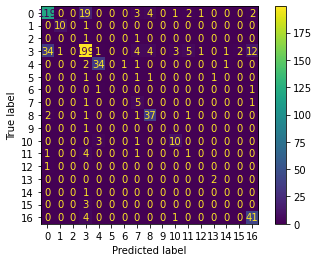

In [40]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_test, y_test["Категория"])


# Сделаем предсказание для теста

In [41]:
df_test = pd.read_csv("./content/test_dataset_test.csv")

In [42]:
df_test['plain'] = df_test["Текст Сообщения"].apply(lambda str: cleanhtml(str))

In [43]:
df_test['text'] = df_test['plain'].map(lambda str: str.lower())
#df_test['text'] = df_test["text"].apply(lambda str: parse_date(str))
#df_test['text'] = df_test["text"].apply(lambda str: mark_numbers(str))

#df_test['text'] = df_test['text'].apply(lambda str: mystem.lemmatize(str))
df_test['text'] = df_test["text"].apply(lambda str: nltk.tokenize.word_tokenize(str))
df_test['text'] = df_test['text'].apply(lambda str: [morph.parse(token)[0].normal_form for token in str])

#df_test['text'] = df_test["text"].apply(lambda str: nltk.tokenize.word_tokenize(str))

df_test['text'] = df_test['text'].map(lambda str: [token for token in str if token not in string.punctuation])

df_test['text'] = df_test['text'].map(lambda str: [token for token in str if token not in nltk.corpus.stopwords.words("russian")])

df_test['text'] = df_test['text'].map(lambda str: [token for token in str if token.isalpha()])

df_test['text'] = df_test['text'].map(lambda str:' '.join(str))

In [44]:
#bag_of_words_test = vectorizer.transform(df_test["text"])
bow1_test = vectorizer.transform(df_test["text"])
#df_cvect_test = pd.DataFrame(bag_of_words_test.toarray(), columns = feature_names)
Xtest = pd.DataFrame(bow1_test.toarray(), columns  = dic_vocabulary)


In [45]:
Xtest

,дорога,дорожный,светофор,ям,знак,переход,покрытие,пешеходный,дорожный покрытие,пешеходный переход,...,улкарл маркс,устранять проблема,хотеть устранять,км черта,рекультивировать,рекультивировать полигон,тбо чаплыгин,чаплыгин,чаплыгин км,черта курск
0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.368432,0.0,0.0,0.533062,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
testY = clf.predict(Xtest)

In [47]:
testY

array([[ 0],
       [ 3],
       [ 3],
       [16],
       [ 8],
       [ 8],
       [ 3],
       [ 3],
       [ 3],
       [ 4],
       [10],
       [ 3],
       [ 3],
       [ 3],
       [16],
       [ 0],
       [ 8],
       [ 3],
       [16],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 3],
       [16],
       [ 3],
       [ 3],
       [10],
       [ 3],
       [16],
       [10],
       [ 0],
       [ 3],
       [ 8],
       [ 3],
       [ 0],
       [ 4],
       [ 0],
       [ 3],
       [16],
       [ 0],
       [ 3],
       [ 1],
       [ 8],
       [ 3],
       [ 7],
       [ 4],
       [ 0],
       [ 8],
       [ 3],
       [ 0],
       [ 8],
       [ 3],
       [ 3],
       [ 0],
       [ 8],
       [ 8],
       [ 1],
       [16],
       [ 0],
       [ 3],
       [ 8],
       [ 0],
       [ 1],
       [ 3],
       [ 3],
       [ 3],
       [16],
       [ 8],
       [ 3],
       [ 0],
       [16],
       [ 0],
       [16],
       [ 0],
       [ 0],
       [16],

In [48]:
submit_df=pd.DataFrame([[name, pred[0]] for name, pred in zip(df_test["id"], testY)], columns=["id", "Категория"])

In [49]:
submit_df

,id,Категория
0,843,0
1,1422,3
2,2782,3
3,2704,16
4,1,8
...,...,...
995,2619,16
996,2518,3
997,2524,0
998,1577,4


In [50]:
submit_df.to_csv("submit.csv", index=False)